In [1]:
# define libraries to use
import pandas as pd
import numpy as np
from pathlib import Path
import requests,json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as sp
%matplotlib inline

def millions(x,pos):
    return '%1.1fM' % (x * 1e-6)

# variables that need initialization

# dict of dataframes
# FARS
farsDf = {}
# CRRS
#crssDf = {}
# NY state vehicle registrations
#nydmvDf = None

# Main Table
farsMainTbl = "accident"
farsKey = "ST_CASE"
crssMainTbl = "accident"
crssKey = "CASENUM"

def bulkreadcsv2df(myFolder, printProgress = False, lowMemory = True):
    """read each csv file in a folder into a df, each df added to as a separate dictionary entry with index a filename"""
    p = Path(myFolder)
    resDct = {}
    fileList = list(p.glob("*.CSV")) + list(p.glob("*.csv"))
    # sort file list based on stem of filename in lowercase
    fileList = sorted(fileList,key=lambda ppath: str(ppath.stem).lower())
    for myFile in fileList:
        dfName = myFile.stem.lower()
        if printProgress:
            print("Reading ",dfName)
        resDct[dfName] = pd.read_csv(str(myFile),encoding = 'unicode_escape', low_memory=lowMemory)

    return resDct



In [2]:
farsDf = bulkreadcsv2df("data/FARS2020NationalCSV/", lowMemory= False)
#crssDf = bulkreadcsv2df("data/CRSS2020CSV/", lowMemory= False)
#nydmvDf = pd.read_csv("data/nydmv/nydmv.csv",encoding = "unicode_escape", low_memory=False)

print("FARS Tables = ",list(farsDf.keys()))
#print("CRSS Tables = ",list(crssDf.keys()))

FARS Tables =  ['accident', 'cevent', 'crashrf', 'damage', 'distract', 'drimpair', 'driverrf', 'drugs', 'factor', 'maneuver', 'miacc', 'midrvacc', 'miper', 'nmcrash', 'nmdistract', 'nmimpair', 'nmprior', 'parkwork', 'pbtype', 'person', 'personrf', 'pvehiclesf', 'race', 'safetyeq', 'vehicle', 'vehiclesf', 'vevent', 'violatn', 'vision', 'vpicdecode', 'vpictrailerdecode', 'vsoe', 'weather']


In [3]:
print("                               F    A    R    S                                                           ")
for idx in farsDf.keys():
    print("==========================================================================================================")
    print("=                                                                                                        =")
    print("=",idx)
    farsDf[idx].info(verbose=True,show_counts=True)
    print("=                                                                                                        =")
    print("==========================================================================================================")


                               F    A    R    S                                                           
=                                                                                                        =
= accident
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35766 entries, 0 to 35765
Data columns (total 81 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   STATE         35766 non-null  int64  
 1   STATENAME     35766 non-null  object 
 2   ST_CASE       35766 non-null  int64  
 3   VE_TOTAL      35766 non-null  int64  
 4   VE_FORMS      35766 non-null  int64  
 5   PVH_INVL      35766 non-null  int64  
 6   PEDS          35766 non-null  int64  
 7   PERSONS       35766 non-null  int64  
 8   PERMVIT       35766 non-null  int64  
 9   PERNOTMVIT    35766 non-null  int64  
 10  COUNTY        35766 non-null  int64  
 11  COUNTYNAME    35766 non-null  object 
 12  CITY          35766 non-null  int64  
 13  CITYNAME      35

In [4]:
# miscelanous pre-checks
#import tabulate

#pd.DataFrame(farsDf["vehicle"][["BODY_TYP","BODY_TYPNAME"]].value_counts().rename("COUNT")).to_csv("tmp/BODY_TYP.csv")
#pd.DataFrame(farsDf["vehicle"][["VPICBODYCLASS","VPICBODYCLASSNAME"]].value_counts().rename("COUNT")).to_csv("tmp/VPICBODYCLASS.csv")
#pd.DataFrame(farsDf["vehicle"][["BODY_TYP","BODY_TYPNAME","VPICBODYCLASS","VPICBODYCLASSNAME"]].value_counts().rename("COUNT")).to_csv("tmp/BODY_TYP_VPICBODYCLASS.csv")
#pd.DataFrame(farsDf["vehicle"][["BODY_TYP","BODY_TYPNAME","VPICBODYCLASS","VPICBODYCLASSNAME","GVWR_FROMNAME"]].value_counts().rename("COUNT")).to_csv("tmp/BODY_TYP_VPICBODYCLASS_GVWR.csv")
#pd.DataFrame(farsDf["vpicdecode"][["BodyClassId","BodyClass","DoorsCount","SeatsCount","GrossVehicleWeightRatingFrom","GrossVehicleWeightRatingTo"]].value_counts(dropna=False).rename("COUNT")).to_csv("tmp/VPIC-BODYCLASS-DRS-STS-GVWR.csv")
#farsDf["vpicdecode"][["BodyClassId","BodyClass","DoorsCount","SeatsCount","GrossVehicleWeightRatingFrom","GrossVehicleWeightRatingTo"]].info()
#farsDf["vpicdecode"][["SeatsCount"]].value_counts()
pd.DataFrame(pd.merge(farsDf["vehicle"],farsDf["vpicdecode"], on = ["ST_CASE","VEH_NO"])[["BODY_TYP","BODY_TYPNAME","VPICBODYCLASS","VPICBODYCLASSNAME","GVWR_FROMNAME","GVWR_TONAME","BodyClassId","BodyClass","DoorsCount","EngineCylindersCount","SeatsCount","GrossVehicleWeightRatingFrom","GrossVehicleWeightRatingTo"]].value_counts(dropna=False).rename("COUNT")).to_csv("tmp/BODY_TYP_VPICBODYCLASS_GVWR_DRS_SEAT.csv")
#farsDf["vehicle"]["VIN"].value_counts().sort_values(ascending=False)
#farsDf["vehicle"][farsDf["vehicle"]["VPICBODYCLASS"]==1]["MAK_MODNAME"].value_counts().sort_values(ascending=False)


In [5]:
#print("                               C    R    S    S                                                           ")
#for idx in crssDf.keys():
#    print("==========================================================================================================")
#    print("=                                                                                                        =")
#    print("=",idx)
#    crssDf[idx].info(verbose=True,show_counts=True)
#    print("=                                                                                                        =")
#    print("==========================================================================================================")


# FARS Table Cleanup to reduce to columns of interest and remove redundant data

## Create Categorical variables based on data

Pandas categorical data type not used so as to keep the original category codes

In [6]:
# farsCategories will hold the categorical mappings for categorical colums

farsCategories = {}

farsCategoricalColumns = {
    "accident" : [
        ["STATE","STATENAME"],
        ["MONTH","MONTHNAME"],
        ["DAY_WEEK","DAY_WEEKNAME"],
        ["ROUTE","ROUTENAME"],
        ["RUR_URB","RUR_URBNAME"],
        ["FUNC_SYS","FUNC_SYSNAME"],
        ["HARM_EV","HARM_EVNAME"],
        ["MAN_COLL","MAN_COLLNAME"],
        #["RELJCT1","RELJCT1NAME"],
        ["LGT_COND","LGT_CONDNAME"],
        ["WEATHER","WEATHERNAME"]
    ],
    "vehicle" : [
        ["NUMOCCS","NUMOCCSNAME"],
        ["MAKE","MAKENAME"],
        ["MAK_MOD","MAK_MODNAME"],
        ["BODY_TYP","BODY_TYPNAME"],
        ["TOW_VEH","TOW_VEHNAME"],
        ["TRAV_SP","TRAV_SPNAME"],
        ["ROLLOVER","ROLLOVERNAME"],
        ["M_HARM","M_HARMNAME"],
        ["DR_PRES","DR_PRESNAME"],
        ["L_STATUS","L_STATUSNAME"],
        ["L_TYPE","L_TYPENAME"],
        ["PREV_ACC","PREV_ACCNAME"],
        ["PREV_DWI","PREV_DWINAME"],
        ["PREV_SPD","PREV_SPDNAME"],
        ["PREV_OTH","PREV_OTHNAME"],
        ["SPEEDREL","SPEEDRELNAME"],
        ["VSURCOND","VSURCONDNAME"],
        ["P_CRASH2","P_CRASH2NAME"],
        ["ACC_TYPE","ACC_TYPENAME"],
        ["DR_DRINK","DR_DRINKNAME"],
        ["VPICMAKE","VPICMAKENAME"],
        ["VPICMODEL","VPICMODELNAME"],
        ["VPICBODYCLASS","VPICBODYCLASSNAME"],
        ["GVWR_FROM","GVWR_FROMNAME"],
        ["GVWR_TO","GVWR_TONAME"],
    ],
    "person" : [
        ["SEX","SEXNAME"],
        ["PER_TYP","PER_TYPNAME"],
        ["INJ_SEV","INJ_SEVNAME"],
        ["SEAT_POS","SEAT_POSNAME"],
        ["REST_USE","REST_USENAME"],
        ["AIR_BAG","AIR_BAGNAME"],
        ["EJECTION","EJECTIONNAME"],
        ["LOCATION","LOCATIONNAME"]
    ],
    "parkwork" : [
		["PNUMOCCS","PNUMOCCSNAME"],
		["PTYPE","PTYPENAME"],
		["PMAKE","PMAKENAME"],
		["PMAK_MOD","PBODYTYP"],
		["PTRAILER","PTRAILERNAME"],
		["PM_HARM","PM_HARMNAME"],
    ],
    "pbtype" : [
        ["PBPTYPE","PBPTYPENAME"],
        ["PBAGE","PBAGENAME"],
        ["PBSEX","PBSEXNAME"],
    ],
    "vevent" : [
        ["AOI1","AOI1NAME"],
        ["AOI2","AOI2NAME"],
    ],
    "crashrf" : [
        ["CRASHRF","CRASHRFNAME"],
    ],
    "driverrf" : [
        ["DRIVERRF","DRIVERRFNAME"],
    ],
    "distract" : [
        ["DRDISTRACT","DRDISTRACTNAME"],
    ],
    "drimpair" : [
        ["DRIMPAIR", "DRIMPAIRNAME"],
    ],
    "factor" : [
        ["VEHICLECC","VEHICLECCNAME"],
    ],
    "vision" : [
        ["VISION", "VISIONNAME"],
    ],
    "nmcrash" : [
        ["NMCC","NMCCNAME"],
    ],
    "vpicdecode" : [
        ["VehicleTypeId","VehicleType"],
		["ManufacturerFullNameId","ManufacturerFullName"],
		["MakeId","Make"],
		["ModelId","Model"],
		["BodyClassId","BodyClass"],
        ["GrossVehicleWeightRatingFromId","GrossVehicleWeightRatingFrom"],
        ["GrossVehicleWeightRatingToId","GrossVehicleWeightRatingTo"],
        # safety features
		["ForwardCollisionWarningId","ForwardCollisionWarning"],
		["DynamicBrakeSupportId","DynamicBrakeSupport"],
		["CrashImminentBrakingID","CrashImminentBraking"],
		["PedestrianAutoEmergencyBrakingId","PedestrianAutoEmergencyBraking"],
		["BlindSpotWarningId","BlindSpotWarning"],
		["BlindSpotInterventionId","BlindSpotIntervention"],
		["LaneDepartureWarningId","LaneDepartureWarning"],
		["LaneKeepingAssistanceId","LaneKeepingAssistance"],
		["LaneCenteringAssistanceId","LaneCenteringAssistance"],
		["BackupCameraId","BackupCamera"],
		["RearCrossTrafficAlertId","RearCrossTrafficAlert"],
		["RearAutomaticEmergencyBrakingId","RearAutomaticEmergencyBraking"],
		["ParkAssistId","ParkAssist"],
		["DaytimeRunningLightId","DaytimeRunningLight"],
		["HeadlampLightSourceId","HeadlampLightSource"],
		["SemiAutoHeadlampBeamSwitchingId","SemiAutoHeadlampBeamSwitching"],
		["AdaptiveDrivingBeamId","AdaptiveDrivingBeam"],
		["AdaptiveCruiseControlId","AdaptiveCruiseControl"],
		["AntilockBrakeSystemId","AntilockBrakeSystem"],
		["ElectronicStabilityControlId","ElectronicStabilityControl"],
		["TPMSId","TPMS"],
		["TractionControlId","TractionControl"],
		["AutoPedestrianAlertingSoundId","AutoPedestrianAlertingSound"],
    ]
}

for dataFile in farsCategoricalColumns.keys():
    print(dataFile, "======================================")
    for catCol in farsCategoricalColumns[dataFile]:
        print(catCol, end=",")
        farsCategories[catCol[0]] = dict(np.array(farsDf[dataFile][catCol].drop_duplicates()))
    print()



accident ======================================
['STATE', 'STATENAME'],['MONTH', 'MONTHNAME'],['DAY_WEEK', 'DAY_WEEKNAME'],['ROUTE', 'ROUTENAME'],['RUR_URB', 'RUR_URBNAME'],['FUNC_SYS', 'FUNC_SYSNAME'],['HARM_EV', 'HARM_EVNAME'],['MAN_COLL', 'MAN_COLLNAME'],['LGT_COND', 'LGT_CONDNAME'],['WEATHER', 'WEATHERNAME'],
vehicle ======================================
['NUMOCCS', 'NUMOCCSNAME'],['MAKE', 'MAKENAME'],['MAK_MOD', 'MAK_MODNAME'],['BODY_TYP', 'BODY_TYPNAME'],['TOW_VEH', 'TOW_VEHNAME'],['TRAV_SP', 'TRAV_SPNAME'],['ROLLOVER', 'ROLLOVERNAME'],['M_HARM', 'M_HARMNAME'],['DR_PRES', 'DR_PRESNAME'],['L_STATUS', 'L_STATUSNAME'],['L_TYPE', 'L_TYPENAME'],['PREV_ACC', 'PREV_ACCNAME'],['PREV_DWI', 'PREV_DWINAME'],['PREV_SPD', 'PREV_SPDNAME'],['PREV_OTH', 'PREV_OTHNAME'],['SPEEDREL', 'SPEEDRELNAME'],['VSURCOND', 'VSURCONDNAME'],['P_CRASH2', 'P_CRASH2NAME'],['ACC_TYPE', 'ACC_TYPENAME'],['DR_DRINK', 'DR_DRINKNAME'],['VPICMAKE', 'VPICMAKENAME'],['VPICMODEL', 'VPICMODELNAME'],['VPICBODYCLASS', 'VPICB

In [7]:
# FARS non-categorical Columns

farsNumericalColumns = {
    "accident" : [
		"ST_CASE",
		"VE_TOTAL",
		"VE_FORMS",
		"PVH_INVL",
		"PEDS",
		"PERSONS",
		"PERMVIT",
		"PERNOTMVIT",
		"DAY",
		"YEAR",
		"HOUR",
		"MINUTE",
		"FATALS",
    ],
    "vehicle" : [
		"ST_CASE",
		"VEH_NO",
		"MOD_YEAR",
		"VIN",
		"DEATHS",
    ],
    "person" : [
		"ST_CASE",
		"VEH_NO",
		"PER_NO",
		"STR_VEH",
		"AGE",
    ],
    "parkwork" : [
		"ST_CASE",
		"VEH_NO",
		"PBODYTYPNAME",
		"PMODYEAR",
		"PVIN",
		"PDEATHS",
    ],
    "pbtype" : [
		"ST_CASE",
		"VEH_NO",
		"PER_NO",
    ],
    "vevent" : [
		"ST_CASE",
		"VEH_NO",
		"VEVENTNUM",
		"VNUMBER1",
		"VNUMBER2",
		"VNUMBER2NAME",
    ],
    "crashrf" : [
		"ST_CASE",
    ],
    "driverrf" : [
		"ST_CASE",
		"VEH_NO",
    ],
    "distract" : [
		"ST_CASE",
		"VEH_NO",
    ],
    "drimpair" : [
		"ST_CASE",
		"VEH_NO",
    ],
    "factor" : [
		"ST_CASE",
		"VEH_NO",
    ],
    "vision" : [
		"ST_CASE",
		"VEH_NO",
    ],
    "nmcrash" : [
		"ST_CASE",
		"VEH_NO",
		"PER_NO",
    ],
	"vpicdecode" : [
		"ST_CASE",
		"VEH_NO",
		"VehicleDescriptor",
		"VINDecodeError",
		"ModelYear",
		"Series",
		"Trim",
		"Series2",
		"Trim2",
		#"CurbWeightLB", mostly not present
		"DoorsCount",
		"SeatsCount",
		"EngineCylindersCount",
	]
} 

# Drop all columns except chosen ones
for dataFile in farsNumericalColumns.keys():
	print(dataFile, "======================================")
	# all columns
	columnSet = set(farsDf[dataFile].columns)
	for catCol in farsCategoricalColumns[dataFile]:
		# remove categorical index column so that it is preserved (not dropped)
		columnSet.remove(catCol[0])
	for catCol in farsNumericalColumns[dataFile]:
		# remove numerical column we want to preserve (not dropped)
		columnSet.remove(catCol)
	# remove unwanted columns
	farsDf[dataFile].drop(columns = columnSet,inplace = True)
	print(farsDf[dataFile].columns)

accident ======================================
Index(['STATE', 'ST_CASE', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS',
       'PERSONS', 'PERMVIT', 'PERNOTMVIT', 'DAY', 'MONTH', 'YEAR', 'DAY_WEEK',
       'HOUR', 'MINUTE', 'ROUTE', 'RUR_URB', 'FUNC_SYS', 'HARM_EV', 'MAN_COLL',
       'LGT_COND', 'WEATHER', 'FATALS'],
      dtype='object')
vehicle ======================================
Index(['ST_CASE', 'VEH_NO', 'NUMOCCS', 'MAKE', 'MAK_MOD', 'BODY_TYP',
       'MOD_YEAR', 'VIN', 'TOW_VEH', 'TRAV_SP', 'ROLLOVER', 'M_HARM',
       'DR_PRES', 'L_STATUS', 'L_TYPE', 'PREV_ACC', 'PREV_DWI', 'PREV_SPD',
       'PREV_OTH', 'SPEEDREL', 'VSURCOND', 'P_CRASH2', 'ACC_TYPE', 'DEATHS',
       'DR_DRINK', 'VPICMAKE', 'VPICMODEL', 'VPICBODYCLASS', 'GVWR_FROM',
       'GVWR_TO'],
      dtype='object')
person ======================================
Index(['ST_CASE', 'VEH_NO', 'PER_NO', 'STR_VEH', 'AGE', 'SEX', 'PER_TYP',
       'INJ_SEV', 'SEAT_POS', 'REST_USE', 'AIR_BAG', 'EJECTION', 'LOCATION'],
      

In [8]:
#pd.DataFrame(farsCategories["HARM_EV"],columns=["id","name"]).to_csv("HARM_EV.csv")

# add simplified HARM_EV category HARM_EV_SIMP, and simplified PHARM_EV_SIMP
farsCategories["HARM_EV_SIMP"] = dict(
    [
        [1,"Animal"],
	    [2,"Building"],
	    [3,"Fixed object"],
	    [4,"Jackknife"],
	    [5,"Motor Vehicle In-Transport"],
	    [6,"Non-Collision"],
	    [7,"Non-Motorist on Personal Conveyance"],
	    [8,"Object not-fixed"],
	    [9,"Parked Motor Vehicle"],
	    [10,"Road Surface"],
	    [11,"Pedalcyclist"],
	    [12,"Pedestrian"],
	    [13,"Railway Vehicle"],
	    [14,"Rollover/Overturn"],
	    [15,"Snow Bank"],
	    [16,"Traffic Barrier"],
	    [17,"Working Motor Vehicle"],
	    [99,"Unknown"]
    ]
)
#farsCategories["PHARM_EV_SIMP"] = farsCategories["HARM_EV_SIMP"].copy()

# HARM_EV mapping to HARM_EV_SIMP
harmEvSimpMap = {
	1 : 14,
	2 : 6,
	3 : 6,
	5 : 6,
	6 : 6,
	7 : 6,
	8 : 12,
	9 : 11,
	10 : 13,
	11 : 1,
	12 : 5,
	14 : 9,
	15 : 7,
	16 : 8,
	17 : 8,
	18 : 8,
	19 : 2,
	20 : 16,
	21 : 16,
	23 : 16,
	24 : 16,
	25 : 16,
	26 : 16,
	30 : 3,
	31 : 3,
	32 : 3,
	33 : 3,
	34 : 3,
	35 : 3,
	38 : 3,
	39 : 3,
	40 : 3,
	41 : 3,
	42 : 3,
	43 : 3,
	44 : 10,
	45 : 17,
	46 : 16,
	48 : 15,
	49 : 1,
	50 : 16,
	51 : 4,
	52 : 16,
	53 : 3,
	54 : 5,
	55 : 5,
	57 : 3,
	58 : 10,
	59 : 3,
	72 : 8,
	73 : 8,
	74 : 13,
	91 : 8,
	93 : 3,
	98 : 99,
	99 : 99,
}

# new columns based on mappings
farsDf["accident"]["HARM_EV_SIMP"] = farsDf["accident"].apply(lambda row: harmEvSimpMap[row["HARM_EV"]],axis=1)
farsDf["parkwork"]["PM_HARM_SIMP"] = farsDf["parkwork"].apply(lambda row: harmEvSimpMap[row["PM_HARM"]],axis=1)

In [9]:
farsDf["accident"].info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35766 entries, 0 to 35765
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   STATE         35766 non-null  int64
 1   ST_CASE       35766 non-null  int64
 2   VE_TOTAL      35766 non-null  int64
 3   VE_FORMS      35766 non-null  int64
 4   PVH_INVL      35766 non-null  int64
 5   PEDS          35766 non-null  int64
 6   PERSONS       35766 non-null  int64
 7   PERMVIT       35766 non-null  int64
 8   PERNOTMVIT    35766 non-null  int64
 9   DAY           35766 non-null  int64
 10  MONTH         35766 non-null  int64
 11  YEAR          35766 non-null  int64
 12  DAY_WEEK      35766 non-null  int64
 13  HOUR          35766 non-null  int64
 14  MINUTE        35766 non-null  int64
 15  ROUTE         35766 non-null  int64
 16  RUR_URB       35766 non-null  int64
 17  FUNC_SYS      35766 non-null  int64
 18  HARM_EV       35766 non-null  int64
 19  MAN_COLL      35766 non-n

In [10]:
farsDf["accident"].describe(include="all")

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERSONS,PERMVIT,PERNOTMVIT,DAY,...,MINUTE,ROUTE,RUR_URB,FUNC_SYS,HARM_EV,MAN_COLL,LGT_COND,WEATHER,FATALS,HARM_EV_SIMP
count,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,...,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000
mean,27.158307,272387.092937,1.560113,1.517419,0.042694,0.228485,2.172818,2.162585,0.238718,15.705139,...,29.241123,3.901079,1.662025,6.038193,18.311357,1.928927,1.961052,9.724683,1.085500,7.306856
std,16.354713,163438.330390,0.782449,0.736814,0.292877,0.470604,1.593437,1.589051,0.494223,8.820912,...,18.540796,2.291921,0.894967,14.282173,14.440480,6.235890,1.222222,25.543251,0.342381,5.920611
min,1.000000,10001.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,12.000000,122077.500000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,8.000000,...,14.000000,2.000000,1.000000,3.000000,8.000000,0.000000,1.000000,1.000000,1.000000,3.000000
50%,26.000000,260916.500000,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,16.000000,...,30.000000,3.000000,2.000000,4.000000,12.000000,0.000000,2.000000,1.000000,1.000000,5.000000
75%,42.000000,420476.750000,2.000000,2.000000,0.000000,0.000000,3.000000,3.000000,0.000000,23.000000,...,45.000000,6.000000,2.000000,5.000000,30.000000,2.000000,3.000000,2.000000,1.000000,12.000000
max,56.000000,560115.000000,15.000000,15.000000,10.000000,8.000000,61.000000,61.000000,9.000000,31.000000,...,99.000000,9.000000,9.000000,99.000000,99.000000,99.000000,9.000000,99.000000,8.000000,99.000000


In [11]:
farsDf["vehicle"].info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54272 entries, 0 to 54271
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ST_CASE        54272 non-null  int64 
 1   VEH_NO         54272 non-null  int64 
 2   NUMOCCS        54272 non-null  int64 
 3   MAKE           54272 non-null  int64 
 4   MAK_MOD        54272 non-null  int64 
 5   BODY_TYP       54272 non-null  int64 
 6   MOD_YEAR       54272 non-null  int64 
 7   VIN            54264 non-null  object
 8   TOW_VEH        54272 non-null  int64 
 9   TRAV_SP        54272 non-null  int64 
 10  ROLLOVER       54272 non-null  int64 
 11  M_HARM         54272 non-null  int64 
 12  DR_PRES        54272 non-null  int64 
 13  L_STATUS       54272 non-null  int64 
 14  L_TYPE         54272 non-null  int64 
 15  PREV_ACC       54272 non-null  int64 
 16  PREV_DWI       54272 non-null  int64 
 17  PREV_SPD       54272 non-null  int64 
 18  PREV_OTH       54272 non-n

In [12]:
farsDf["vehicle"].describe(include="all")

,ST_CASE,VEH_NO,NUMOCCS,MAKE,MAK_MOD,BODY_TYP,MOD_YEAR,VIN,TOW_VEH,TRAV_SP,...,VSURCOND,P_CRASH2,ACC_TYPE,DEATHS,DR_DRINK,VPICMAKE,VPICMODEL,VPICBODYCLASS,GVWR_FROM,GVWR_TO
count,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54264,54272.000000,54272.000000,...,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000,54272.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47307,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999999999999,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1490,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,272436.583929,1.440356,4.208874,38.219192,38591.625884,28.574366,2265.710366,NaN,0.120504,621.607625,...,3.041126,42.230321,45.521484,0.573316,0.175579,3741.310639,7807.022369,57.885926,14.101452,14.105100
std,163467.099399,0.751221,16.238331,26.638260,26784.205497,29.328485,1409.115325,NaN,0.724640,466.022955,...,13.238901,29.386049,35.774018,0.586123,0.380465,17213.376896,18576.720294,160.479531,14.170733,14.170731
min,10001.000000,1.000000,0.000000,2.000000,2001.000000,1.000000,1923.000000,NaN,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,440.000000,1684.000000,1.000000,11.000000,11.000000
25%,122139.000000,1.000000,1.000000,18.000000,18019.000000,4.000000,2004.000000,NaN,0.000000,55.000000,...,1.000000,13.000000,13.000000,0.000000,0.000000,460.000000,1857.000000,7.000000,11.000000,11.000000
50%,260834.000000,1.000000,1.000000,35.000000,35049.000000,14.000000,2010.000000,NaN,0.000000,998.000000,...,1.000000,51.000000,50.000000,1.000000,0.000000,474.000000,2166.000000,13.000000,11.000000,11.000000
75%,420521.250000,2.000000,2.000000,54.000000,54035.000000,34.000000,2016.000000,NaN,0.000000,998.000000,...,1.000000,64.000000,83.000000,1.000000,0.000000,496.000000,4308.000000,60.000000,12.000000,12.000000


In [13]:
print(farsDf["vehicle"]["MOD_YEAR"].describe())
print(farsDf["vehicle"]["MOD_YEAR"].value_counts().sort_values())

count    54272.000000
mean      2265.710366
std       1409.115325
min       1923.000000
25%       2004.000000
50%       2010.000000
75%       2016.000000
max       9999.000000
Name: MOD_YEAR, dtype: float64
1930       1
1965       1
1952       1
1955       1
1927       1
        ... 
2017    2633
2015    2666
2019    2719
2007    2813
2016    2868
Name: MOD_YEAR, Length: 83, dtype: int64


In [14]:
farsDf["vpicdecode"].info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52890 entries, 0 to 52889
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ST_CASE                           52890 non-null  int64  
 1   VEH_NO                            52890 non-null  int64  
 2   VehicleDescriptor                 52890 non-null  object 
 3   VINDecodeError                    52890 non-null  object 
 4   VehicleTypeId                     52890 non-null  int64  
 5   ManufacturerFullNameId            52890 non-null  int64  
 6   MakeId                            52890 non-null  int64  
 7   ModelId                           52888 non-null  float64
 8   ModelYear                         52890 non-null  int64  
 9   Series                            32036 non-null  object 
 10  Trim                              18339 non-null  object 
 11  Series2                           7817 non-null   object 
 12  Trim

In [15]:
farsDf["vpicdecode"].describe(include="all")

,ST_CASE,VEH_NO,VehicleDescriptor,VINDecodeError,VehicleTypeId,ManufacturerFullNameId,MakeId,ModelId,ModelYear,Series,...,DaytimeRunningLightId,HeadlampLightSourceId,SemiAutoHeadlampBeamSwitchingId,AdaptiveDrivingBeamId,AdaptiveCruiseControlId,AntilockBrakeSystemId,ElectronicStabilityControlId,TPMSId,TractionControlId,AutoPedestrianAlertingSoundId
count,52890.000000,52890.000000,52890,52890,52890.000000,52890.000000,52890.000000,52888.000000,52890.000000,32036,...,10319.000000,6017.00000,10490.000000,7572.000000,7690.000000,6782.000000,5504.0,20126.000000,5269.000000,6021.000000
unique,NaN,NaN,23217,7,NaN,NaN,NaN,NaN,NaN,2390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,1N4AL3AP*FC******,0,NaN,NaN,NaN,NaN,NaN,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,72,52236,NaN,NaN,NaN,NaN,NaN,1010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,273558.101134,1.483210,NaN,NaN,3.669938,1315.258537,654.980753,4231.305268,2009.135073,NaN,...,0.469425,0.11883,0.477979,0.441891,0.484265,1.001622,1.0,1.076965,1.001139,0.075237
std,163345.070857,0.801542,NaN,NaN,2.459962,1576.933663,792.316004,4636.948324,7.242620,NaN,...,0.556909,0.55184,0.557446,0.909847,0.958537,0.050044,0.0,0.266729,0.047714,0.337304
min,10001.000000,1.000000,NaN,NaN,1.000000,955.000000,440.000000,1684.000000,1981.000000,NaN,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,1.000000,0.000000
25%,122233.250000,1.000000,NaN,NaN,2.000000,984.000000,460.000000,1852.000000,2004.000000,NaN,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.000000
50%,260906.000000,1.000000,NaN,NaN,3.000000,994.000000,474.000000,2073.000000,2009.000000,NaN,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.000000
75%,420604.750000,2.000000,NaN,NaN,7.000000,1034.000000,485.000000,3286.000000,2015.000000,NaN,...,1.000000,0.00000,1.000000,0.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000


In [16]:
print(farsDf["accident"].columns.values)
print(farsDf["vehicle"].columns.values)
print(farsDf["vpicdecode"].columns.values)

['STATE' 'ST_CASE' 'VE_TOTAL' 'VE_FORMS' 'PVH_INVL' 'PEDS' 'PERSONS'
 'PERMVIT' 'PERNOTMVIT' 'DAY' 'MONTH' 'YEAR' 'DAY_WEEK' 'HOUR' 'MINUTE'
 'ROUTE' 'RUR_URB' 'FUNC_SYS' 'HARM_EV' 'MAN_COLL' 'LGT_COND' 'WEATHER'
 'FATALS' 'HARM_EV_SIMP']
['ST_CASE' 'VEH_NO' 'NUMOCCS' 'MAKE' 'MAK_MOD' 'BODY_TYP' 'MOD_YEAR' 'VIN'
 'TOW_VEH' 'TRAV_SP' 'ROLLOVER' 'M_HARM' 'DR_PRES' 'L_STATUS' 'L_TYPE'
 'PREV_ACC' 'PREV_DWI' 'PREV_SPD' 'PREV_OTH' 'SPEEDREL' 'VSURCOND'
 'P_CRASH2' 'ACC_TYPE' 'DEATHS' 'DR_DRINK' 'VPICMAKE' 'VPICMODEL'
 'VPICBODYCLASS' 'GVWR_FROM' 'GVWR_TO']
['ST_CASE' 'VEH_NO' 'VehicleDescriptor' 'VINDecodeError' 'VehicleTypeId'
 'ManufacturerFullNameId' 'MakeId' 'ModelId' 'ModelYear' 'Series' 'Trim'
 'Series2' 'Trim2' 'BodyClassId' 'DoorsCount'
 'GrossVehicleWeightRatingFromId' 'GrossVehicleWeightRatingToId'
 'SeatsCount' 'EngineCylindersCount' 'ForwardCollisionWarningId'
 'DynamicBrakeSupportId' 'CrashImminentBrakingID'
 'PedestrianAutoEmergencyBrakingId' 'BlindSpotWarningId'
 'BlindSpotIn

In [17]:
# verify if all ST_CASE combinations are present
accStCaseSet = set(farsDf["accident"]["ST_CASE"].dropna().unique())
vehStCaseSet = set(farsDf["vehicle"]["ST_CASE"].dropna().unique())
vpicStCaseSet = set(farsDf["vpicdecode"]["ST_CASE"].dropna().unique())

print(len(accStCaseSet),len(vehStCaseSet),len(vpicStCaseSet))
print("Set diff 'accident' - 'vehicle' \t=\t",len(accStCaseSet.copy().difference(vehStCaseSet)))
print("Set diff 'accident' - 'vpicdecode' \t=\t",len(accStCaseSet.copy().difference(vpicStCaseSet)))
print("Set diff 'vehicle' - 'vpicdecode' \t=\t",len(vehStCaseSet.copy().difference(vpicStCaseSet)))
print("Set diff 'vpicdecode' - 'vehicle' \t=\t",len(vpicStCaseSet.copy().difference(vehStCaseSet)))
print(len(accStCaseSet),len(vehStCaseSet),len(vpicStCaseSet))

# there are cases without vpicdecode entries, all cases have vehicle entries

# find cases without vpic decode entry
tempDf = farsDf["accident"][~farsDf["accident"]["ST_CASE"].isin(vpicStCaseSet)]
accCountWithoutVPIC = len(tempDf)

# find all vehicles wihtout vpic decode entry
temp2Df = farsDf["vehicle"][~farsDf["vehicle"]["ST_CASE"].isin(vpicStCaseSet)]
vehBodyTypeWithoutVPIC = temp2Df.apply(lambda row: farsCategories["BODY_TYP"][row["BODY_TYP"]],axis=1).value_counts()
vehMakeWithoutVPIC = temp2Df.apply(lambda row: farsCategories["MAKE"][row["MAKE"]],axis=1).value_counts()
vehModelYearWithoutVPIC = temp2Df["MOD_YEAR"].value_counts()
vehCountWithoutVPIC = len(temp2Df)
print("total accidents wiht vehicles wihtout VPIC =\t",accCountWithoutVPIC,accCountWithoutVPIC/len(farsDf["accident"])*100,"%")
print("total vehicles wihtout VPIC =\t\t\t",vehCountWithoutVPIC,vehCountWithoutVPIC/len(farsDf["vehicle"])*100,"%")
print("Most frequent Body Type without VPIC =\t",vehBodyTypeWithoutVPIC.head(1).index[0],"\tfreq =",vehBodyTypeWithoutVPIC.head(1)[0],vehBodyTypeWithoutVPIC.head(1)[0]/vehCountWithoutVPIC*100,"%")
print("Most frequent Make without VPIC =\t",vehMakeWithoutVPIC.head(1).index[0],"\t\tfreq =",vehMakeWithoutVPIC.head(1)[0],vehMakeWithoutVPIC.head(1)[0]/vehCountWithoutVPIC*100,"%")
print("Most frequent Model Year without VPIC =\t",vehModelYearWithoutVPIC.head(1).index[0],"\t\t\tfreq =",vehModelYearWithoutVPIC.head(1).values[0],vehModelYearWithoutVPIC.head(1).values[0]/vehCountWithoutVPIC*100,"%")

tempDf = None
temp2Df = None

print(farsDf["vehicle"]["MOD_YEAR"].drop_duplicates().sort_values().values)
print(farsDf["vpicdecode"]["ModelYear"].drop_duplicates().sort_values().values)

35766 35766 34148
Set diff 'accident' - 'vehicle' 	=	 0
Set diff 'accident' - 'vpicdecode' 	=	 1618
Set diff 'vehicle' - 'vpicdecode' 	=	 1618
Set diff 'vpicdecode' - 'vehicle' 	=	 0
35766 35766 34148
total accidents wiht vehicles wihtout VPIC =	 1618 4.523849465973271 %
total vehicles wihtout VPIC =			 1706 3.14342570754717 %
Most frequent Body Type without VPIC =	 Unknown body type 	freq = 890 52.16881594372802 %
Most frequent Make without VPIC =	 Unknown Make 		freq = 978 57.327080890973036 %
Most frequent Model Year without VPIC =	 9999 			freq = 1085 63.59906213364596 %
[1923 1927 1930 1932 1936 1937 1940 1946 1947 1948 1949 1950 1951 1952
 1953 1954 1955 1957 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 9998 99

In [18]:
# remove accidents and vehicles without vpic decode
# vehicles without vpic record
farsDf["vehicle"] = pd.merge(farsDf["vehicle"],farsDf["vpicdecode"], on = ["ST_CASE","VEH_NO"])[farsDf["vehicle"].columns]
# remove accidents that have vehicles without vpic records
farsDf["accident"] = farsDf["accident"][farsDf["accident"]["ST_CASE"].isin(set(farsDf["vehicle"]["ST_CASE"].dropna().unique()))].copy()


# FARS Data Verification

In [19]:
totalAcc = len(farsDf["accident"])

In [20]:
accStatesDf = pd.DataFrame(farsDf["accident"]["STATE"].value_counts().sort_values(ascending=False).head(14))
accStatesDf.columns = ["TotalAcc"]
accStatesDf["STATE"] = accStatesDf.index.values
accStatesDf["STATE"] = accStatesDf.apply(lambda row: farsCategories["STATE"][row["STATE"]],axis=1)
accStatesDf.loc["Others"] = [farsDf["accident"]["STATE"].count() - accStatesDf["TotalAcc"].sum(),"Others"]
accStatesDf.set_index("STATE",inplace=True)
accStatesDf

,TotalAcc
STATE,
Texas,3373
California,3340
Florida,2970
Georgia,1463
North Carolina,1376
Ohio,1109
Tennessee,1057
Illinois,1020
Pennsylvania,1011


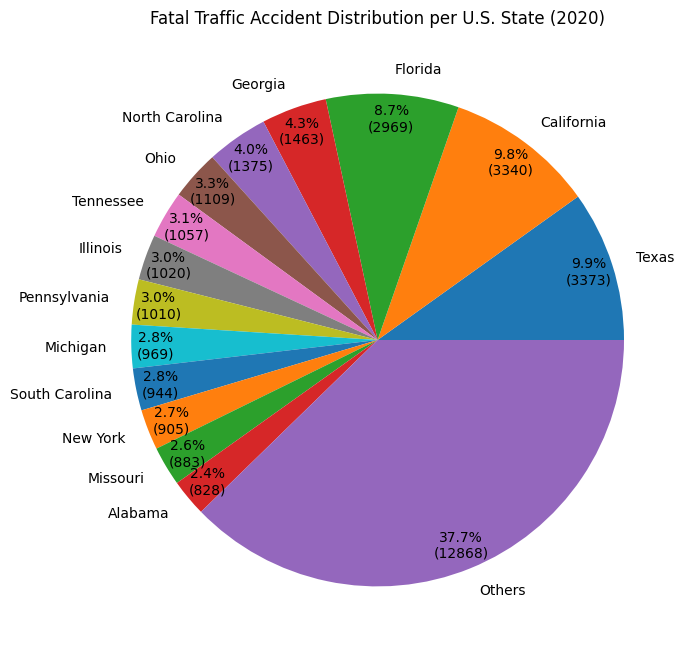

In [21]:

def func(pct):
    absolute = int(pct/100.*farsDf["accident"]["STATE"].count())
    return "{:.1f}%\n({:d})".format(pct, absolute)

#autopct = "%1.1f%%" if not using function

_ = accStatesDf.plot.pie(y="TotalAcc",figsize=(8,8),legend = False, title = "Fatal Traffic Accident Distribution per U.S. State (2020)", \
    ylabel = "", autopct=lambda pct: func(pct), pctdistance = 0.9, rotatelabels = False)



In [22]:
accTotalsDf = pd.DataFrame(dict(farsDf["accident"][["VE_TOTAL","VE_FORMS","PVH_INVL","PERSONS","PERMVIT","PERNOTMVIT","PEDS","FATALS"]].sum()),index = ["Total"])
accTotalsDf["Fatal Accidents"] = len(farsDf["accident"])
accTotalsDf["Occupants in Parked and Work Vehicles"] = accTotalsDf["PERNOTMVIT"] - accTotalsDf["PEDS"]
accTotalsDf = accTotalsDf.reindex(columns=['Fatal Accidents', 'VE_TOTAL', "VE_FORMS", 'PVH_INVL', 'PERSONS', 'PERMVIT', 'PERNOTMVIT', "Occupants in Parked and Work Vehicles",'PEDS','FATALS'])
accTotalsDf.columns = ['Total Fatal Accidents', 'Total Vehicles', "Vehicles in Transport",'Parked and Working Vehicles', 'Vehicle Occupants', 'Occupants in Vehicles in Transport', 'Persons Not in Motor Vehicles in Transport', "Occupants in Parked and Work Vehicles", 'Person not in Vehicles','Fatalities']
accTotalsDf

,Total Fatal Accidents,Total Vehicles,Vehicles in Transport,Parked and Working Vehicles,Vehicle Occupants,Occupants in Vehicles in Transport,Persons Not in Motor Vehicles in Transport,Occupants in Parked and Work Vehicles,Person not in Vehicles,Fatalities
Total,34119,54020,52537,1483,75664,75301,7497,363,7134,37141


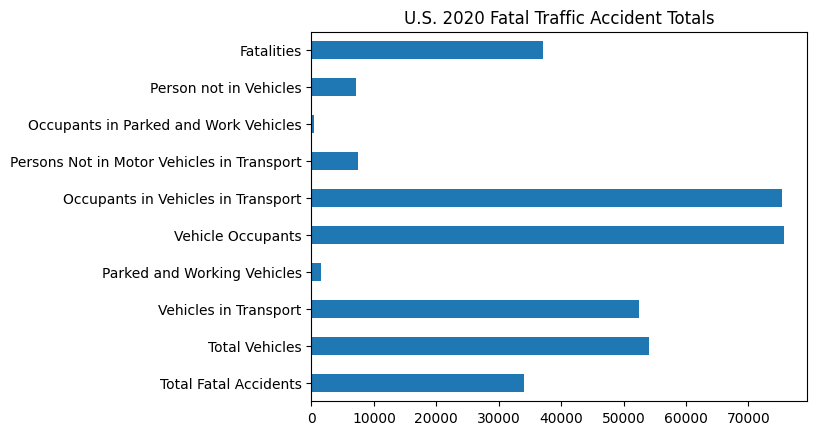

In [23]:
accTotalsSer = accTotalsDf.loc["Total"]
ax = accTotalsSer.plot.barh(title = "U.S. 2020 Fatal Traffic Accident Totals")

<AxesSubplot: title={'center': 'Vehicles in Transport vs Parked and Working Vehicles'}>

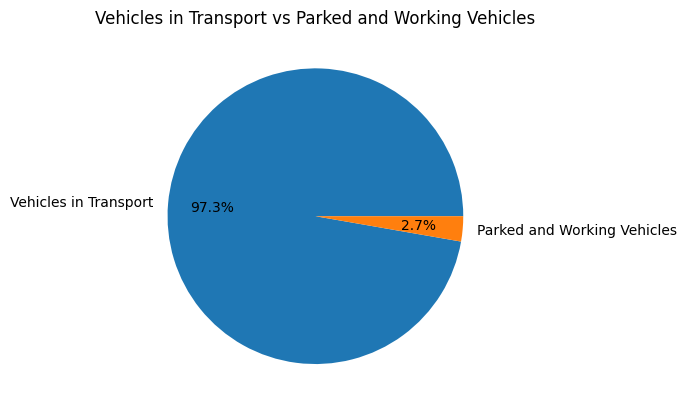

In [24]:
accTotalsDf.loc["Total"][["Vehicles in Transport",'Parked and Working Vehicles']].plot.pie(legend = False, title = "Vehicles in Transport vs Parked and Working Vehicles", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

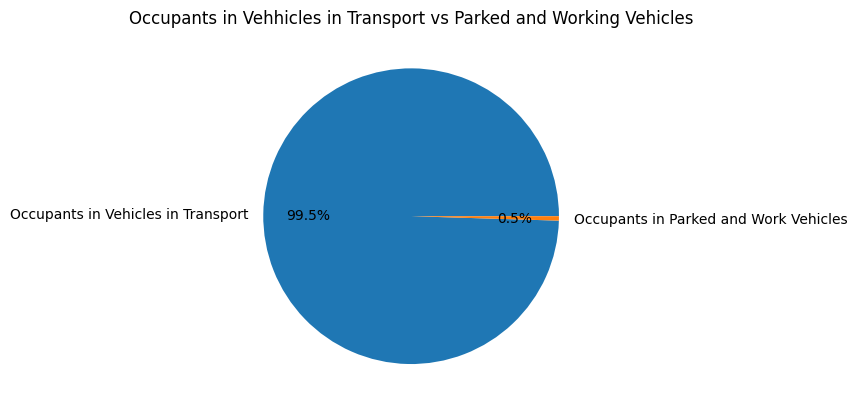

In [25]:
_ = accTotalsDf.loc["Total"][['Occupants in Vehicles in Transport',"Occupants in Parked and Work Vehicles"]].plot.pie(legend = False, title = "Occupants in Vehhicles in Transport vs Parked and Working Vehicles", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [26]:
# accidents by month
accMonthDf = pd.DataFrame(farsDf["accident"]["MONTH"].value_counts()).sort_index()
accMonthDf.columns = ["TotalAcc"]
accMonthDf["MONTH"] = accMonthDf.index.values
accMonthDf["MONTH"] = accMonthDf.apply(lambda row: farsCategories["MONTH"][row["MONTH"]],axis=1)
#accMonthDf.loc["Others"] = [farsDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accMonthDf.set_index("MONTH",inplace=True)
accMonthDf

,TotalAcc
MONTH,
January,2384
February,2358
March,2272
April,2029
May,2726
June,3231
July,3290
August,3367
September,3255


<AxesSubplot: title={'center': 'U.S. 2020 Fatal Traffic Accident per Month'}, xlabel='MONTH', ylabel='Total Falta Accidents'>

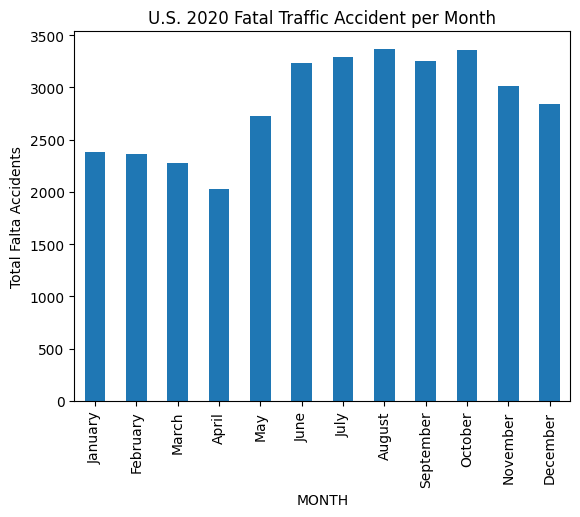

In [27]:
accMonthDf.plot.bar(title = "U.S. 2020 Fatal Traffic Accident per Month",legend = False, ylabel = "Total Falta Accidents")

In [28]:
# accidents by day of the week
accDayWeekDf = pd.DataFrame(farsDf["accident"]["DAY_WEEK"].value_counts()).sort_index()
accDayWeekDf.columns = ["TotalAcc"]
accDayWeekDf["DAY_WEEK"] = accDayWeekDf.index.values
accDayWeekDf["DAY_WEEK"] = accDayWeekDf.apply(lambda row: farsCategories["DAY_WEEK"][row["DAY_WEEK"]],axis=1)
#accMonthDf.loc["Others"] = [farsDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accDayWeekDf.set_index("DAY_WEEK",inplace=True)
accDayWeekDf

,TotalAcc
DAY_WEEK,
Sunday,5292
Monday,4263
Tuesday,4336
Wednesday,4487
Thursday,4634
Friday,5241
Saturday,5866


<AxesSubplot: title={'center': 'U.S. 2020 Fatal Traffic Accident per Day of the Week'}, xlabel='Day of the Week', ylabel='Total Falta Accidents'>

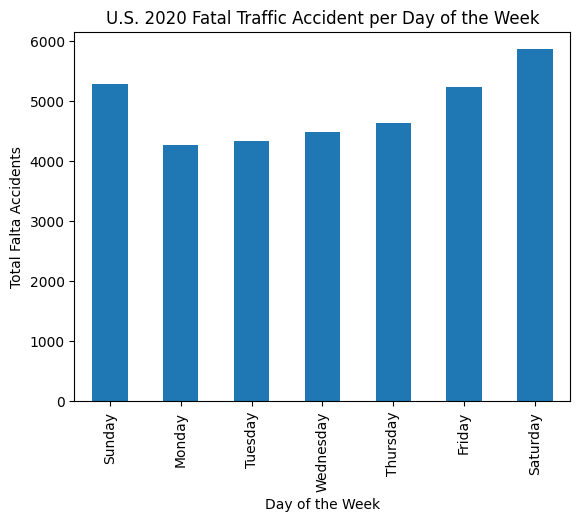

In [29]:
accDayWeekDf.plot.bar(title = "U.S. 2020 Fatal Traffic Accident per Day of the Week",legend = False, ylabel = "Total Falta Accidents", \
    xlabel = "Day of the Week")

In [30]:
# accidents and weather events
accWeatherDf = pd.DataFrame(farsDf["accident"]["WEATHER"].value_counts().sort_values(ascending=False))
accWeatherDf.columns = ["TotalAccidents"]
totalWeatherAcc = accWeatherDf["TotalAccidents"].sum()
accWeatherDf["WEATHER"] = accWeatherDf.index.values
accWeatherDf["WEATHER"] = accWeatherDf.apply(lambda row: farsCategories["WEATHER"][row["WEATHER"]],axis=1)
accWeatherDf.set_index("WEATHER",inplace=True)
# combined unknown and not reported rows
accWeatherDf.loc["Unknown"] = accWeatherDf.loc["Not Reported"] + accWeatherDf.loc["Reported as Unknown"]
accWeatherDf.drop(index=["Reported as Unknown","Not Reported"],inplace=True)
accWeatherDf

,TotalAccidents
WEATHER,
Clear,23905
Cloudy,4450
Rain,2544
"Fog, Smog, Smoke",352
Snow,278
Severe Crosswinds,54
Freezing Rain or Drizzle,38
Blowing Snow,26
Sleet or Hail,26


/var/folders/4d/pq_2_fgs7s3bjnxxpgksl2880000gn/T/ipykernel_36912/3199826246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accWeatherDf.loc["Other"] = [totalWeatherAcc - accWeatherDf["TotalAccidents"].sum()]


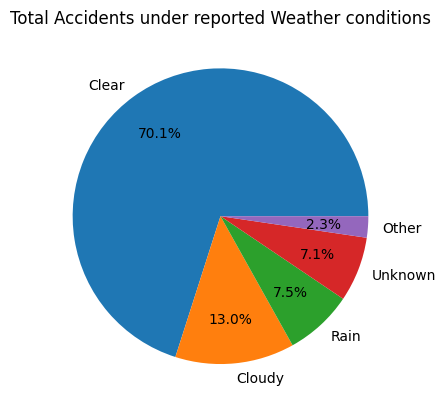

In [31]:
accWeatherDf = accWeatherDf[accWeatherDf["TotalAccidents"] > 2000]
accWeatherDf.loc["Other"] = [totalWeatherAcc - accWeatherDf["TotalAccidents"].sum()]
_ = accWeatherDf["TotalAccidents"].plot.pie(legend = False, title = "Total Accidents under reported Weather conditions", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [32]:
# accidents and light condition
accLightDf = pd.DataFrame(farsDf["accident"]["LGT_COND"].value_counts().sort_values(ascending=False))
accLightDf.columns = ["TotalAccidents"]
totalAcc = accLightDf["TotalAccidents"].sum()
accLightDf["LGT_COND"] = accLightDf.index.values
accLightDf["LGT_COND"] = accLightDf.apply(lambda row: farsCategories["LGT_COND"][row["LGT_COND"]],axis=1)
accLightDf.set_index("LGT_COND",inplace=True)
# combined unknown and not reported rows
#accLightDf.loc["Unknown"] = accWeatherDf.loc["Not Reported"] + accWeatherDf.loc["Reported as Unknown"]
#accLightDf.drop(index=["Reported as Unknown","Not Reported"],inplace=True)
accLightDf

,TotalAccidents
LGT_COND,
Daylight,15903
Dark - Not Lighted,9350
Dark - Lighted,6877
Dusk,923
Dawn,630
Dark - Unknown Lighting,267
Reported as Unknown,111
Not Reported,43
Other,15


/var/folders/4d/pq_2_fgs7s3bjnxxpgksl2880000gn/T/ipykernel_36912/2954352009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accLightDf.loc["Other"] = [totalAcc - accLightDf["TotalAccidents"].sum()]


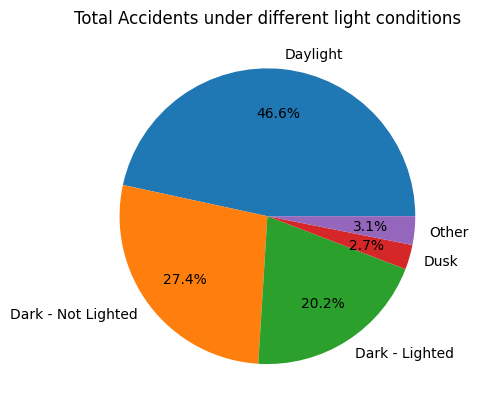

In [33]:
accLightDf = accLightDf[accLightDf["TotalAccidents"] > 900]
accLightDf.loc["Other"] = [totalAcc - accLightDf["TotalAccidents"].sum()]
_ = accLightDf["TotalAccidents"].plot.pie(legend = False, title = "Total Accidents under different light conditions", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [34]:
# accidents harmul events
accHarmEvDf = pd.DataFrame(farsDf["accident"]["HARM_EV_SIMP"].value_counts().sort_values(ascending=False))
accHarmEvDf.columns = ["TotalAccidents"]
accHarmEvDf["HARM_EV_SIMP"] = accHarmEvDf.index.values
accHarmEvDf["HARM_EV_SIMP"] = accHarmEvDf.apply(lambda row: farsCategories["HARM_EV_SIMP"][row["HARM_EV_SIMP"]],axis=1)
#accMonthDf.loc["Others"] = [farsDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accHarmEvDf.set_index("HARM_EV_SIMP",inplace=True)
totalAcc = accHarmEvDf["TotalAccidents"].sum()
accHarmEvDf

,TotalAccidents
HARM_EV_SIMP,
Motor Vehicle In-Transport,13589
Fixed object,8737
Pedestrian,5104
Rollover/Overturn,2544
Traffic Barrier,1619
Pedalcyclist,826
Parked Motor Vehicle,439
Object not-fixed,305
Non-Collision,260


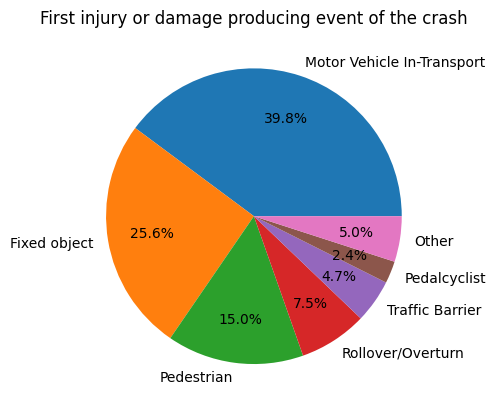

In [35]:
accHarmEvDf = accHarmEvDf[accHarmEvDf["TotalAccidents"] > 500].copy()
accHarmEvDf.loc["Other"] = [totalAcc - accHarmEvDf["TotalAccidents"].sum()]
_ = accHarmEvDf["TotalAccidents"].plot.pie(legend = False, title = "First injury or damage producing event of the crash", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [36]:
# for Events including Motort Vehicle in Transport orientation of montor vehicles
accManCollDf = pd.DataFrame(farsDf["accident"]["MAN_COLL"].value_counts().sort_values(ascending=False))
accManCollDf.columns = ["TotalAccidents"]
accManCollDf["MAN_COLL"] = accManCollDf.index.values
accManCollDf["MAN_COLL"] = accManCollDf.apply(lambda row: farsCategories["MAN_COLL"][row["MAN_COLL"]],axis=1)
#accMonthDf.loc["Others"] = [farsDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accManCollDf.set_index("MAN_COLL",inplace=True)
accManCollDf.drop(index=["The First Harmful Event was Not a Collision with a Motor Vehicle in Transport"],inplace=True)
totMVinTransportAcc = accManCollDf["TotalAccidents"].sum()
accManCollDf

,TotalAccidents
MAN_COLL,
Angle,6416
Front-to-Front,3619
Front-to-Rear,2418
Sideswipe - Same Direction,527
Sideswipe - Opposite Direction,420
Other,101
Not Reported,34
Rear-to-Side,30
Reported as Unknown,27


/var/folders/4d/pq_2_fgs7s3bjnxxpgksl2880000gn/T/ipykernel_36912/3567835035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accManCollDf.loc["Other"] = [totMVinTransportAcc - accManCollDf["TotalAccidents"].sum()]


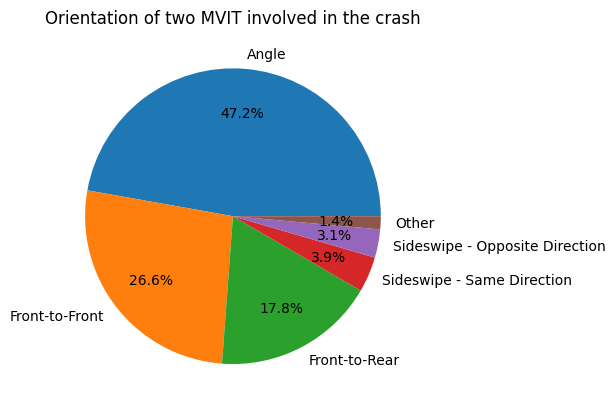

In [37]:
# keep evetns that make at least 3% of total
accManCollDf = accManCollDf[accManCollDf["TotalAccidents"]/totMVinTransportAcc >= 0.03]
accManCollDf.loc["Other"] = [totMVinTransportAcc - accManCollDf["TotalAccidents"].sum()]
_ = accManCollDf["TotalAccidents"].plot.pie(legend = False, title = "Orientation of two MVIT involved in the crash", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [38]:
# Vehicle Make 
# accidents harmul events
vehModDf = pd.DataFrame(farsDf["vehicle"]["MAKE"].value_counts().sort_values(ascending=False)).head(20)
vehModDf.columns = ["TotalVehicles"]
vehModDf["MAKE"] = vehModDf.index.values
vehModDf["MAKE"] = vehModDf.apply(lambda row: farsCategories["MAKE"][row["MAKE"]],axis=1)
vehModDf.set_index("MAKE",inplace=True)
totalVeh = len(farsDf["vehicle"])
vehModDf.loc["Others"] = [totalVeh - vehModDf["TotalVehicles"].sum()]
vehModDf


,TotalVehicles
MAKE,
Chevrolet,6991
Ford,6986
Toyota,4317
Honda,4084
Dodge,3180
Nissan/Datsun,2972
Harley-Davidson,2112
GMC,1739
Jeep / Kaiser-Jeep / Willys- Jeep,1528


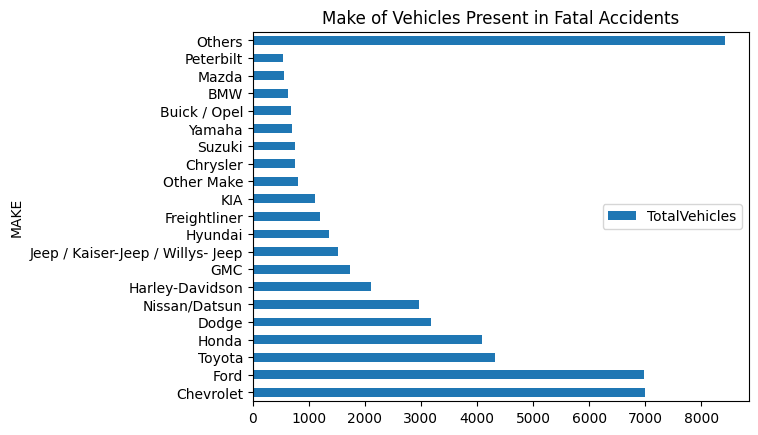

In [39]:
#accTotalsSer = vehModDf.loc["TotalVehicles"]
ax = vehModDf.plot.barh(title = "Make of Vehicles Present in Fatal Accidents")

In [40]:
# Vehicle Model Year
vehYrDf = pd.DataFrame(farsDf["vehicle"]["MOD_YEAR"].value_counts())
vehYrDf.columns = ["TotalVehicles"]
vehYrDf["MOD_YEAR"] = vehYrDf.index.values
#vehYrDf["MAKE"] = vehYrDf.apply(lambda row: farsCategories["MAKE"][row["MAKE"]],axis=1)
#vehYrDf.set_index("MOD_YEAR",inplace=True)
totalVeh = len(farsDf["vehicle"])
#vehYrDf.loc["Others"] = [totalVeh - vehYrDf["TotalVehicles"].sum()]
#vehYrDf.loc["Unknown"] = [vehYrDf.loc[9998]["TotalVehicles"] + vehYrDf.loc[9999]["TotalVehicles"],np.NaN]
#vehYrDf.drop(index=[9998,9999],inplace=True)
vehYrDf

,TotalVehicles,MOD_YEAR
2016,2825,2016
2007,2778,2007
2019,2662,2019
2015,2623,2015
2017,2593,2017
2005,2587,2005
2006,2535,2006
2008,2427,2008
2018,2422,2018
2014,2388,2014


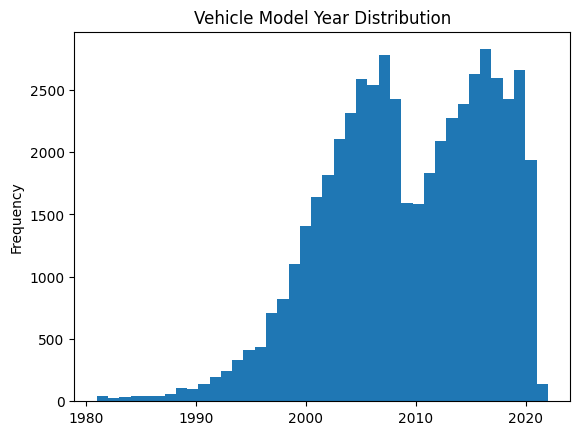

In [41]:
_ = farsDf["vehicle"][farsDf["vehicle"]["MOD_YEAR"] < 9998]["MOD_YEAR"].plot.hist(bins=40,title="Vehicle Model Year Distribution")

Text(0.5, 1.0, 'Vehicle Model Year')

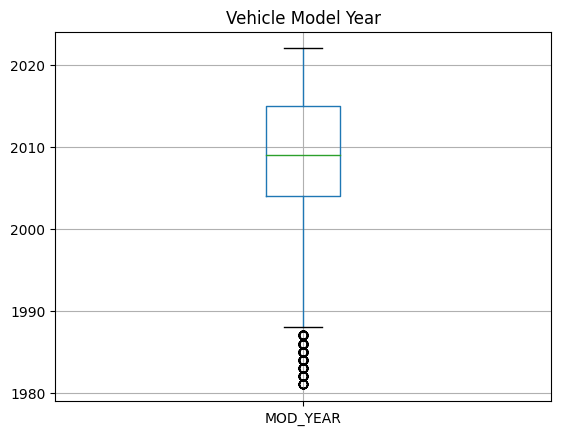

In [42]:
#ax = vehYrDf.boxplot(column="MOD_YEAR")
ax = farsDf["vehicle"][farsDf["vehicle"]["MOD_YEAR"] < 9998].boxplot(column="MOD_YEAR")
ax.set_title("Vehicle Model Year")

In [43]:
# Vehicle Body class
vehBodyDf = pd.DataFrame(farsDf["vehicle"]["VPICBODYCLASS"].value_counts())
vehBodyDf.columns = ["TotalVehicles"]
vehBodyDf["VPICBODYCLASS"] = vehBodyDf.index.values
vehBodyDf["VPICBODYCLASS"] = vehBodyDf.apply(lambda row: farsCategories["VPICBODYCLASS"][row["VPICBODYCLASS"]],axis=1)
vehBodyDf.set_index("VPICBODYCLASS",inplace=True)
vehBodyDf

,TotalVehicles
VPICBODYCLASS,
Sedan/Saloon,14881
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV),11237
Pickup,8959
Truck-Tractor,2760
Coupe,1799
Motorcycle - Sport,1614
Hatchback/Liftback/Notchback,1430
Motorcycle - Touring / Sport Touring,1257
Minivan,1037


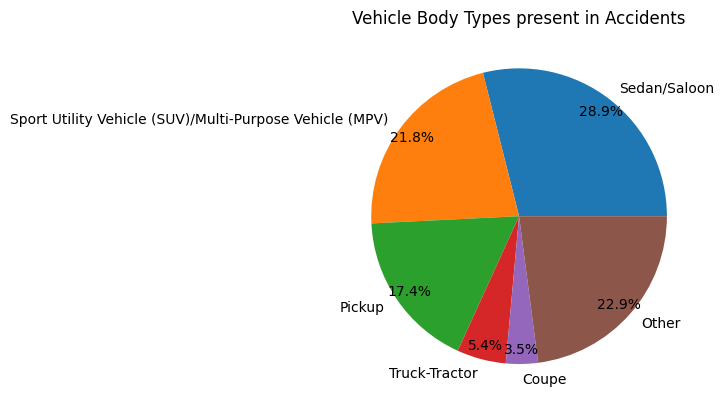

In [44]:
# keep evetns that make at least 3% of total
vehBodyDf = vehBodyDf[vehBodyDf["TotalVehicles"]/totalVeh >= 0.034].copy()
vehBodyDf.loc["Other"] = totalVeh - vehBodyDf["TotalVehicles"].sum()
_ = vehBodyDf["TotalVehicles"].plot.pie(legend = False, title = "Vehicle Body Types present in Accidents", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.9, rotatelabels = False)

In [45]:
# Driver was Drinking
vehDrinkDf = pd.DataFrame(farsDf["vehicle"]["DR_DRINK"].value_counts().sort_values(ascending=False))
vehDrinkDf.columns = ["TotalVehicles"]
vehDrinkDf["DR_DRINK"] = vehDrinkDf.index.values
vehDrinkDf["DR_DRINK"] = vehDrinkDf.apply(lambda row: farsCategories["DR_DRINK"][row["DR_DRINK"]],axis=1)
vehDrinkDf.set_index("DR_DRINK",inplace=True)
totalVeh = len(farsDf["vehicle"])
#vehDrinkDf.loc["Others"] = [totalVeh - vehDrinkDf["TotalVehicles"].sum()]
vehDrinkDf

,TotalVehicles
DR_DRINK,
No,42211
Yes,9224


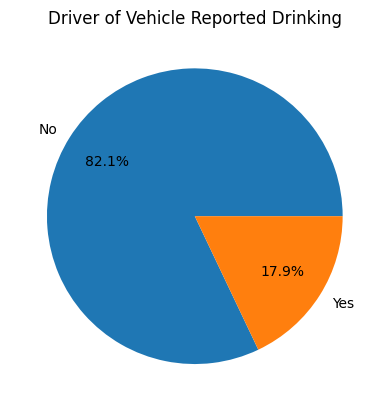

In [46]:
_ = vehDrinkDf["TotalVehicles"].plot.pie(legend = False, title = "Driver of Vehicle Reported Drinking", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [47]:
# simplify access to driver information from "person" table
driversDf = farsDf["person"][farsDf["person"]["PER_TYP"] == 1]
totalDrivers = len(driversDf)

In [48]:
# Driver's Sex
drSexDf = pd.DataFrame(driversDf["SEX"].value_counts().sort_values(ascending=False))
drSexDf.columns = ["TotalDrivers"]
drSexDf["SEX"] = drSexDf.index.values
drSexDf["SEX"] = drSexDf.apply(lambda row: farsCategories["SEX"][row["SEX"]],axis=1)
drSexDf.set_index("SEX",inplace=True)
# Combine 'Reported as Unknown' and 'Not Reported'
drSexDf.loc["Unknown"] = drSexDf.loc["Reported as Unknown"] + drSexDf.loc["Not Reported"]
drSexDf.drop(index=["Reported as Unknown","Not Reported"],inplace=True)
drSexDf

,TotalDrivers
SEX,
Male,39393
Female,13033
Unknown,1464


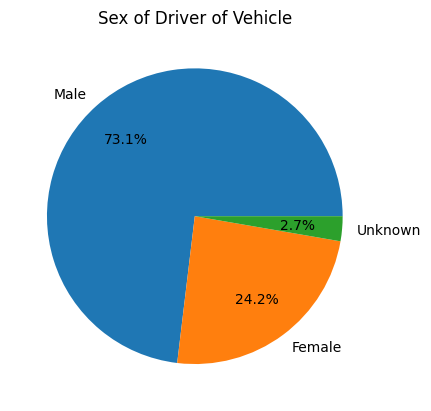

In [49]:
_ = drSexDf["TotalDrivers"].plot.pie(legend = False, title = "Sex of Driver of Vehicle", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [50]:
# Driver's Age
drAgeDf = pd.DataFrame(driversDf["AGE"].value_counts().sort_index())
drAgeDf.columns = ["TotalDrivers"]
drAgeDf["AGE"] = drAgeDf.index.values
#drAgeDf["SEX"] = drAgeDf.apply(lambda row: farsCategories["SEX"][row["SEX"]],axis=1)
#drAgeDf.set_index("AGE",inplace=True)
# Combine 'Reported as Unknown' and 'Not Reported'
drAgeDf.loc["Unknown"] = [drAgeDf.loc[998]["TotalDrivers"] + drAgeDf.loc[999]["TotalDrivers"],np.NaN]
drAgeDf.drop(index=[998,999],inplace=True)
drAgeDf

,TotalDrivers,AGE
7,2.0,7.0
8,2.0,8.0
9,1.0,9.0
10,5.0,10.0
11,3.0,11.0
...,...,...
98,1.0,98.0
99,4.0,99.0
100,1.0,100.0
102,1.0,102.0


In [51]:
drAgeDf["AGE"].describe()

count     95.000000
mean      54.010526
std       27.586419
min        7.000000
25%       30.500000
50%       54.000000
75%       77.500000
max      102.000000
Name: AGE, dtype: float64

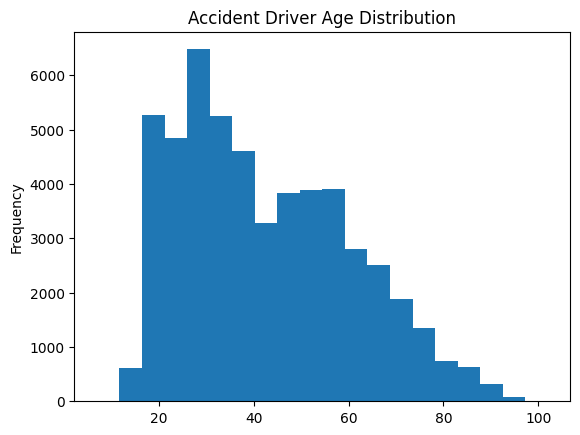

In [52]:
#_ = drAgeDf.drop(index="Unknown").plot.hist(by="TotalDrivers")
_ = driversDf[driversDf["AGE"] < 998]["AGE"].plot.hist(bins=20,title="Accident Driver Age Distribution")

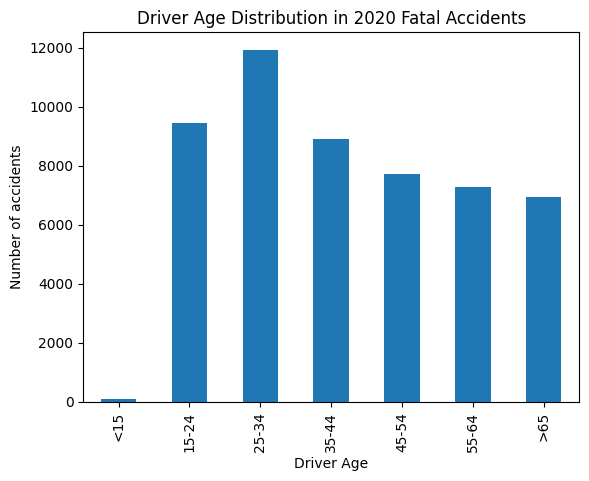

In [53]:
driverAgeCut = pd.cut(driversDf[driversDf["AGE"] < 998]["AGE"],[0,14,24,34,44,54,64,200],labels=["<15","15-24","25-34","35-44","45-54","55-64",">65"])
#_ = driverAgeCut.plot.scatter(title="Accident Driver Age Distribution")
#driverAgeCut.value_counts().plot.bar()
ax = driverAgeCut.value_counts(sort=False).plot.bar(title="Driver Age Distribution in 2020 Fatal Accidents",xlabel="Driver Age",ylabel="Number of accidents")

Text(0.5, 0.98, '')

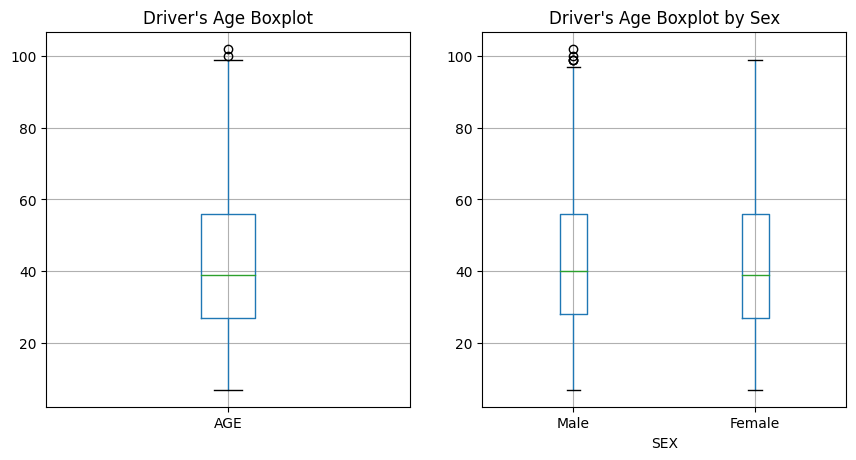

In [54]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
driversDf[driversDf["AGE"] < 998].boxplot(column="AGE",ax=ax1)
ax1.set_title("Driver's Age Boxplot")
driversDf[(driversDf["AGE"] < 998) & (driversDf["SEX"].isin([1,2]))].boxplot(column="AGE",by="SEX",ax=ax2)
ax2.set_title("Driver's Age Boxplot by Sex")
a = ax2.get_xticklabels()
ax2.set_xticklabels([farsCategories["SEX"][int(a[0].get_text())],farsCategories["SEX"][int(a[1].get_text())]])
fig.suptitle("")


## Safety features

In [55]:
safetyFeaturesColumns = [
 	"ForwardCollisionWarningId",
	"DynamicBrakeSupportId",
	"CrashImminentBrakingID",
	"PedestrianAutoEmergencyBrakingId",
	"BlindSpotWarningId",
	"BlindSpotInterventionId",
	"LaneDepartureWarningId",
	"LaneKeepingAssistanceId",
	"LaneCenteringAssistanceId",
	"BackupCameraId",
	"RearCrossTrafficAlertId",
	"RearAutomaticEmergencyBrakingId",
	"ParkAssistId",
	"DaytimeRunningLightId",
	#"HeadlampLightSourceId",
	"SemiAutoHeadlampBeamSwitchingId",
	"AdaptiveDrivingBeamId",
	"AdaptiveCruiseControlId",
	"AntilockBrakeSystemId",
	"ElectronicStabilityControlId",
	"TPMSId",
	"TractionControlId",
	"AutoPedestrianAlertingSoundId",
]

safetyFeaturesNames = {
 	"ForwardCollisionWarningId" : "Forward Collision Warning",
	"DynamicBrakeSupportId" : "Dynamic Brake Support",
	"CrashImminentBrakingID" : "Crash Imminent Braking",
	"PedestrianAutoEmergencyBrakingId" : "Pedestrian Auto Emergency Braking",
	"BlindSpotWarningId" : "Blind Spot Warning",
	"BlindSpotInterventionId": "Blind Spot Intervention",
	"LaneDepartureWarningId" : "Lane Departure Warning",
	"LaneKeepingAssistanceId" : "Lane Keeping Assistance",
	"LaneCenteringAssistanceId" : "Lane Centering Assistance",
	"BackupCameraId" : "Backup Camera",
	"RearCrossTrafficAlertId" : "Rear Cross Traffic Alert",
	"RearAutomaticEmergencyBrakingId" : "Rear Automatic Emergency Braking",
	"ParkAssistId" : "Park Assist",
	"DaytimeRunningLightId" : "Daytime Running Light",
	#"HeadlampLightSourceId",
	"SemiAutoHeadlampBeamSwitchingId" : "Semi Auto Headlamp Beam Switching",
	"AdaptiveDrivingBeamId" : "Adaptive Driving Beam",
	"AdaptiveCruiseControlId" : "Adaptive Cruise Control",
	"AntilockBrakeSystemId" : "Antilock Brake System",
	"ElectronicStabilityControlId" : "Electronic Stability Control",
	"TPMSId" : "Tire Pressure Monitoring System",
	"TractionControlId" : "Traction Control",
	"AutoPedestrianAlertingSoundId" : "Auto Pedestrian Alerting Sound",
}


def AnyStdSafetyFeature(vpicRow):
	"""Returns true if any of the safety features are marked standard for the vehicle checked 
	(vpicdecode columnnames are used)attribute value = 1 means standard
	"""
	
	stdFeatureFlag = False
	for feat in safetyFeaturesColumns:
		stdFeatureFlag = stdFeatureFlag | (vpicRow[feat] == 1)
	return stdFeatureFlag

def GoodVPICDecode(picDecodeResult):
	return (picDecodeResult in {'0','0,10','1,10','1,400','1,10,400'})


In [72]:
# check categories for Safe Features to be used for NYSDMV VPIC DECODE

for col in sorted(safetyFeaturesColumns):
    print(col.ljust(max([len(x) for x in safetyFeaturesColumns])+4),farsCategories[col])

AdaptiveCruiseControlId              {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 3.0: 'Optional', 2.0: 'Not Available'}
AdaptiveDrivingBeamId                {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 3.0: 'Optional', 2.0: 'Not Available'}
AntilockBrakeSystemId                {nan: nan, 1.0: 'Standard', 3.0: 'Optional', 2.0: 'Not Available'}
AutoPedestrianAlertingSoundId        {nan: nan, 0.0: 'Not Applicable', 2.0: 'Not Available', 1.0: 'Standard', 3.0: 'Optional'}
BackupCameraId                       {nan: nan, 1.0: 'Standard', 3.0: 'Optional', 0.0: 'Not Applicable', 2.0: 'Not Available'}
BlindSpotInterventionId              {nan: nan}
BlindSpotWarningId                   {nan: nan, 1.0: 'Standard', 3.0: 'Optional', 0.0: 'Not Applicable', 2.0: 'Not Available'}
CrashImminentBrakingID               {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 3.0: 'Optional', 2.0: 'Not Available'}
DaytimeRunningLightId                {nan: nan, 3.0: 'Optional', 1.0: 'Standard', 0.0:

In [56]:
farsDf["vpicdecode"].info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52890 entries, 0 to 52889
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ST_CASE                           52890 non-null  int64  
 1   VEH_NO                            52890 non-null  int64  
 2   VehicleDescriptor                 52890 non-null  object 
 3   VINDecodeError                    52890 non-null  object 
 4   VehicleTypeId                     52890 non-null  int64  
 5   ManufacturerFullNameId            52890 non-null  int64  
 6   MakeId                            52890 non-null  int64  
 7   ModelId                           52888 non-null  float64
 8   ModelYear                         52890 non-null  int64  
 9   Series                            32036 non-null  object 
 10  Trim                              18339 non-null  object 
 11  Series2                           7817 non-null   object 
 12  Trim

In [57]:
farsDf["vpicdecode"].describe(include="all")

,ST_CASE,VEH_NO,VehicleDescriptor,VINDecodeError,VehicleTypeId,ManufacturerFullNameId,MakeId,ModelId,ModelYear,Series,...,DaytimeRunningLightId,HeadlampLightSourceId,SemiAutoHeadlampBeamSwitchingId,AdaptiveDrivingBeamId,AdaptiveCruiseControlId,AntilockBrakeSystemId,ElectronicStabilityControlId,TPMSId,TractionControlId,AutoPedestrianAlertingSoundId
count,52890.000000,52890.000000,52890,52890,52890.000000,52890.000000,52890.000000,52888.000000,52890.000000,32036,...,10319.000000,6017.00000,10490.000000,7572.000000,7690.000000,6782.000000,5504.0,20126.000000,5269.000000,6021.000000
unique,NaN,NaN,23217,7,NaN,NaN,NaN,NaN,NaN,2390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,1N4AL3AP*FC******,0,NaN,NaN,NaN,NaN,NaN,SE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,72,52236,NaN,NaN,NaN,NaN,NaN,1010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,273558.101134,1.483210,NaN,NaN,3.669938,1315.258537,654.980753,4231.305268,2009.135073,NaN,...,0.469425,0.11883,0.477979,0.441891,0.484265,1.001622,1.0,1.076965,1.001139,0.075237
std,163345.070857,0.801542,NaN,NaN,2.459962,1576.933663,792.316004,4636.948324,7.242620,NaN,...,0.556909,0.55184,0.557446,0.909847,0.958537,0.050044,0.0,0.266729,0.047714,0.337304
min,10001.000000,1.000000,NaN,NaN,1.000000,955.000000,440.000000,1684.000000,1981.000000,NaN,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,1.000000,0.000000
25%,122233.250000,1.000000,NaN,NaN,2.000000,984.000000,460.000000,1852.000000,2004.000000,NaN,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.000000
50%,260906.000000,1.000000,NaN,NaN,3.000000,994.000000,474.000000,2073.000000,2009.000000,NaN,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.000000
75%,420604.750000,2.000000,NaN,NaN,7.000000,1034.000000,485.000000,3286.000000,2015.000000,NaN,...,1.000000,0.00000,1.000000,0.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000


In [58]:
farsDf["vpicdecode"]["VINDecodeError"].value_counts()

0           52236
0,10          401
1             218
1,10           19
1,400           9
400             4
1,10,400        3
Name: VINDecodeError, dtype: int64

In [59]:
badVPICcount = len(farsDf["vpicdecode"]) - (farsDf["vpicdecode"]["VINDecodeError"] == '0').sum()
print("Bad VIN Decodes = ",badVPICcount, "(", badVPICcount/len(farsDf["vpicdecode"])*100,"%)")

Bad VIN Decodes =  654 ( 1.2365286443562111 %)


In [60]:
farsDf["vpicdecode"]["AnySafetyFeature"] = farsDf["vpicdecode"].apply(lambda row: AnyStdSafetyFeature(row),axis=1)
#farsDf["vpicdecode"]["GoodVPICDecode"] = farsDf["vpicdecode"].apply(lambda row: (row["VINDecodeError"] == '0'),axis=1)
farsDf["vpicdecode"]["GoodVPICDecode"] = farsDf["vpicdecode"].apply(lambda row: (GoodVPICDecode(row["VINDecodeError"])),axis=1)


In [61]:
print(farsDf["vpicdecode"]["GoodVPICDecode"].sum())
print(farsDf["vpicdecode"]["AnySafetyFeature"].sum())
badVPICcount = len(farsDf["vpicdecode"]) - farsDf["vpicdecode"]["GoodVPICDecode"].sum()
print("Bad VIN Decodes = ",badVPICcount, "(", badVPICcount/len(farsDf["vpicdecode"])*100,"%)")

52668
20404
Bad VIN Decodes =  222 ( 0.41973908111174135 %)


In [62]:
badVINrecords = farsDf["vpicdecode"][farsDf["vpicdecode"]["GoodVPICDecode"]==False]
badVINrecords

,ST_CASE,VEH_NO,VehicleDescriptor,VINDecodeError,VehicleTypeId,ManufacturerFullNameId,MakeId,ModelId,ModelYear,Series,...,SemiAutoHeadlampBeamSwitchingId,AdaptiveDrivingBeamId,AdaptiveCruiseControlId,AntilockBrakeSystemId,ElectronicStabilityControlId,TPMSId,TractionControlId,AutoPedestrianAlertingSoundId,AnySafetyFeature,GoodVPICDecode
665,10454,1,1GNFK16Z*2J******,1,7,984,467,1851.0,2002,1500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
705,10479,3,3D6WC76A*8G******,1,10,1002,476,1958.0,2008,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1047,10697,1,3VWJM71K*9M******,1,2,1147,482,3137.0,2009,S,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,True,False
1396,40027,1,SALPM164*1A******,1,7,1079,444,2247.0,2001,Feature Specification 2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1769,40305,1,MH3RH15Y*LK******,1,1,1130,564,24541.0,2020,Sport Bike,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50447,510593,1,2FAFP71W*XX******,1,2,977,460,1778.0,1999,Police Interceptor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
51170,530307,1,VBKV1940*GM******,1,1,1165,596,13728.0,2016,Other Usage/On Highway,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,False,False
51861,540232,2,ZACCJBDT*FP******,1,7,1029,483,6160.0,2015,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,True,False
52137,550169,2,KNDEUCAA*M7******,1,7,1034,499,26900.0,2021,S,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,True,False


In [63]:
print("Vehicles in vehicle table vs vpicdecode tables")
print("VPIC entries =",len(farsDf["vpicdecode"]),"Vehicle Entries =",len(farsDf["vehicle"]),"Vehicle Entires with Unkown Year =",(farsDf["vehicle"]["MOD_YEAR"] >= 9998).sum())

Vehicles in vehicle table vs vpicdecode tables
VPIC entries = 52890 Vehicle Entries = 51435 Vehicle Entires with Unkown Year = 0


In [64]:
# Vehicle Safety Features vs Model Year
# join vehicle table with vpictable 
#vehSafetyYrDf = pd.merge(farsDf["vehicle"][farsDf["vehicle"]["MOD_YEAR"] < 9998],farsDf["vpicdecode"], on = ["ST_CASE","VEH_NO"])
vehVpicMergeDf = pd.merge(farsDf["vehicle"],farsDf["vpicdecode"], on = ["ST_CASE","VEH_NO"])
vehSafetyYrDf = vehVpicMergeDf[["MOD_YEAR","AnySafetyFeature"]].groupby("MOD_YEAR").agg(['count','sum'])
vehSafetyYrDf = vehSafetyYrDf["AnySafetyFeature"]
vehSafetyYrDf.columns = ["Total Cars","Cars with Safey Features"]
#vehSafetyYrDf = pd.DataFrame(farsDf["vpicdecode"][["ModelYear","AnySafetyFeature"]].value_counts())
#vehSafetyYrDf.columns = ["TotalVehicles"]
#vehSafetyYrDf["VPICBODYCLASS"] = vehSafetyYrDf.index.values
#vehSafetyYrDf["VPICBODYCLASS"] = vehSafetyYrDf.apply(lambda row: farsCategories["VPICBODYCLASS"][row["VPICBODYCLASS"]],axis=1)
#vehSafetyYrDf.set_index("VPICBODYCLASS",inplace=True)
#vehSafetyYrDf["STATE"] = accStatesDf.apply(lambda row: farsCategories["STATE"][row["STATE"]],axis=1)
vehSafetyYrDf.info(verbose=True,show_counts=True)
#        ["MAKE","MAKENAME"],
#        ["MAK_MOD","MAK_MODNAME"],
##tempDf = vehSafetyYrDf[vehSafetyYrDf["MOD_YEAR"] != vehSafetyYrDf["ModelYear"]][["MOD_YEAR","ModelYear","MAKE","MAK_MOD","MakeId","ModelId"]].copy()
##temp2Df = vehSafetyYrDf[vehSafetyYrDf["MOD_YEAR"] == vehSafetyYrDf["ModelYear"]][["MOD_YEAR","ModelYear","MAKE","MAK_MOD","MakeId","ModelId"]].copy()
##makeMappingVehVpicDf = vehSafetyYrDf[["MAKE","MakeId"]].drop_duplicates().dropna()
##modelMappingVehVpicDf = vehSafetyYrDf[["MAKE","MAK_MOD","MakeId","ModelId"]].drop_duplicates().dropna()

##makeMappingVehVpicDf["MakeVpic"] = makeMappingVehVpicDf.apply(lambda row: farsCategories["MakeId"][row["MakeId"]],axis=1)
##makeMappingVehVpicDf["MAKENAME"] = makeMappingVehVpicDf.apply(lambda row: farsCategories["MAKE"][row["MAKE"]],axis=1)

##modelMappingVehVpicDf["MakeVpic"] = modelMappingVehVpicDf.apply(lambda row: farsCategories["MakeId"][row["MakeId"]],axis=1)
##modelMappingVehVpicDf["MAKENAME"] = modelMappingVehVpicDf.apply(lambda row: farsCategories["MAKE"][row["MAKE"]],axis=1)
##modelMappingVehVpicDf["ModelVpic"] = modelMappingVehVpicDf.apply(lambda row: farsCategories["ModelId"][row["ModelId"]],axis=1)
##modelMappingVehVpicDf["MAK_MODNAME"] = modelMappingVehVpicDf.apply(lambda row: farsCategories["MAK_MOD"][row["MAK_MOD"]],axis=1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 1981 to 2022
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Total Cars                42 non-null     int64
 1   Cars with Safey Features  42 non-null     int64
dtypes: int64(2)
memory usage: 1008.0 bytes


In [65]:
vehSafetyFeatDf = vehVpicMergeDf[["AnySafetyFeature"]].value_counts().rename({True:"Yes", False:"No"})
vehSafetyFeatDf

AnySafetyFeature
No                  31597
Yes                 19838
dtype: int64

In [66]:
print(vehVpicMergeDf["MOD_YEAR"].drop_duplicates().sort_values().values)
print(farsDf["vehicle"]["MOD_YEAR"].drop_duplicates().sort_values().values)
print(farsDf["vpicdecode"]["ModelYear"].drop_duplicates().sort_values().values)

[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


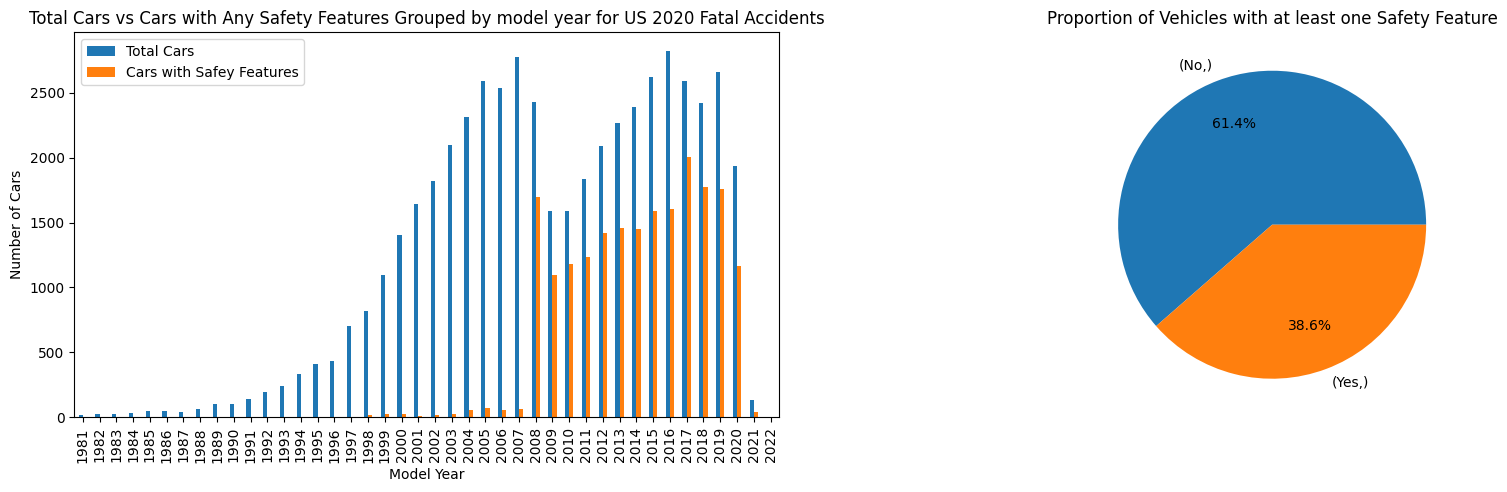

In [67]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
vehSafetyYrDf.plot.bar(stacked=False,ax=ax1)
ax1.set_xlabel("Model Year")
ax1.set_ylabel("Number of Cars")
ax1.set_title("Total Cars vs Cars with Any Safety Features Grouped by model year for US 2020 Fatal Accidents")
vehVpicMergeDf[["AnySafetyFeature"]].value_counts().rename({True:"Yes", False:"No"}).plot.pie(legend = False, \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False, ax=ax2)
_ = ax2.set_title("Proportion of Vehicles with at least one Safety Feature")

In [68]:
tempDf = vehVpicMergeDf[safetyFeaturesColumns].fillna(int(0))
vehSafetyFeaturesCnt = pd.Series(dtype='float64')
print("check values for every safety feature")
for x in tempDf.columns.sort_values():
    vehSafetyFeaturesCnt[safetyFeaturesNames[x]] = (tempDf[x] == 1).sum()/totalVeh*100
    print(x.ljust(max([len(x) for x in tempDf.columns])+2),"\t",str(tempDf[x].drop_duplicates().sort_values().values).ljust(16),(tempDf[x] == 1).sum())
tempDf = None
vehSafetyFeaturesCnt.sort_values(inplace=True)
vehSafetyFeaturesCnt

check values for every safety feature
AdaptiveCruiseControlId            	 [0. 1. 2. 3.]    1061
AdaptiveDrivingBeamId              	 [0. 1. 2. 3.]    1098
AntilockBrakeSystemId              	 [0. 1. 2. 3.]    6603
AutoPedestrianAlertingSoundId      	 [0. 1. 2. 3.]    179
BackupCameraId                     	 [0. 1. 2. 3.]    5063
BlindSpotInterventionId            	 [0.]             0
BlindSpotWarningId                 	 [0. 1. 2. 3.]    1154
CrashImminentBrakingID             	 [0. 1. 2. 3.]    1647
DaytimeRunningLightId              	 [0. 1. 2. 3.]    4368
DynamicBrakeSupportId              	 [0. 1. 2. 3.]    4889
ElectronicStabilityControlId       	 [0. 1.]          5360
ForwardCollisionWarningId          	 [0. 1. 2. 3.]    1699
LaneCenteringAssistanceId          	 [0. 1. 3.]       5
LaneDepartureWarningId             	 [0. 1. 2. 3.]    1420
LaneKeepingAssistanceId            	 [0. 1. 4. 5.]    1244
ParkAssistId                       	 [0. 1. 2. 3.]    191
PedestrianAutoEmergencyBra

Rear Automatic Emergency Braking      0.000000
Blind Spot Intervention               0.000000
Lane Centering Assistance             0.009721
Rear Cross Traffic Alert              0.262467
Auto Pedestrian Alerting Sound        0.348012
Park Assist                           0.371342
Pedestrian Auto Emergency Braking     1.881987
Adaptive Cruise Control               2.062798
Adaptive Driving Beam                 2.134733
Blind Spot Warning                    2.243608
Lane Keeping Assistance               2.418587
Lane Departure Warning                2.760766
Crash Imminent Braking                3.202100
Forward Collision Warning             3.303198
Daytime Running Light                 8.492272
Semi Auto Headlamp Beam Switching     8.828619
Dynamic Brake Support                 9.505201
Backup Camera                         9.843492
Traction Control                      9.969865
Electronic Stability Control         10.420920
Antilock Brake System                12.837562
Tire Pressure

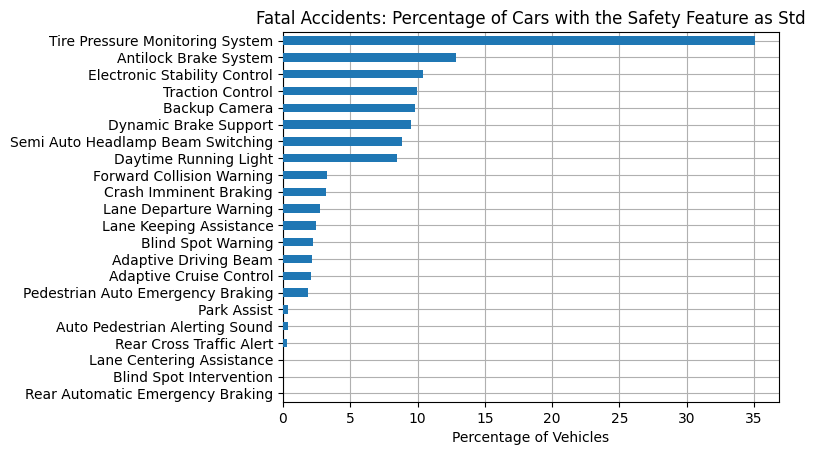

In [69]:
ax = vehSafetyFeaturesCnt.plot.barh(title="Fatal Accidents: Percentage of Cars with the Safety Feature as Std",zorder=3)
ax.set_xlabel("Percentage of Vehicles")
ax.grid()